# NFT GAN

What do the most expensive, most sought-after NFTs have in common? Truth is, we don't know. But using the power of GANs we might be able to find out.

In [1]:
import torch as T
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as Transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from ai import *
from networks import MyGAN
from tqdm import tqdm
from torchvision.utils import save_image
import os

### Image Hyper Parameters

In [2]:
image_size = 512
batch_size = 64
latent_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

### Load Dataset

In [3]:
train_ds = ImageFolder("dataset/", transform=Transforms.Compose([
    Transforms.Resize(image_size),
    Transforms.CenterCrop(image_size),
    Transforms.ToTensor(),
    Transforms.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [4]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

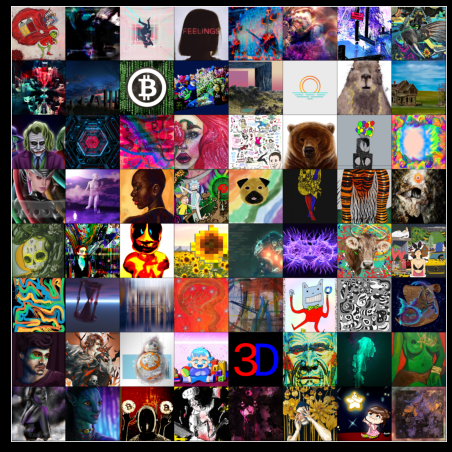

In [5]:
show_batch(train_dl)

torch.Size([64, 3, 512, 512])


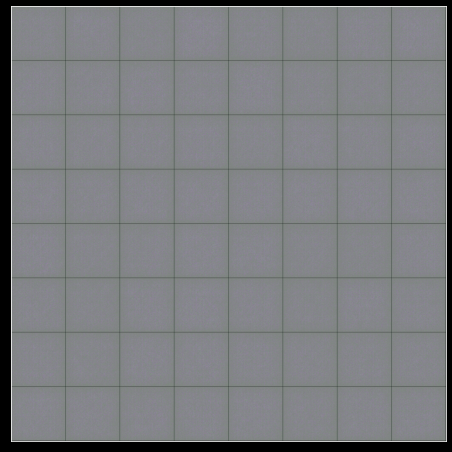

In [6]:
gan_model = MyGAN(latent_size, image_size, batch_size)

xb = T.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = gan_model.generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [7]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [8]:
def save_samples(index, latent_tensors, show=True):
    fake_images = gan_model.generator(latent_tensors)
    fake_fname = "generated-images-{0:0=4d}.png".format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print("Saving", fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Load stuff into the device

In [9]:
device = get_default_device()
gan_model.to_device(device)
train_dl = DeviceDataLoader(train_dl, device)

In [10]:
epochs = 200
lr = 0.0004
start_idx = 1

In [11]:
fixed_latent = T.randn(64, latent_size, 1, 1, device=gan_model.device)

Saving generated-images-0000.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


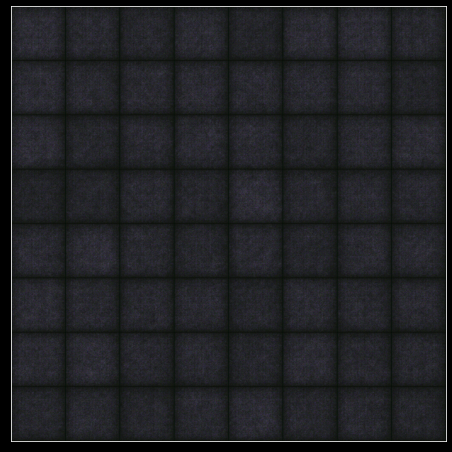

In [12]:
save_samples(0, fixed_latent)

### Train GAN

In [13]:
T.cuda.empty_cache()

print(f"Discriminator parameters count: {count_parameters(gan_model.discriminator)}")
print(f"Generator parameters count: {count_parameters(gan_model.generator)}")

# Losses & scores
losses_g = []
losses_d = []
real_scores = []
fake_scores = []

# Create optimizers
opt_d = T.optim.Adam(gan_model.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_g = T.optim.Adam(gan_model.generator.parameters(), lr=lr, betas=(0.5, 0.999))

for epoch in range(epochs):
    
    for real_images, _ in tqdm(train_dl):
        # Train discriminator
        loss_d, real_score, fake_score = gan_model.train_discriminator(real_images, opt_d)
        # Train generator
        loss_g = gan_model.train_generator(opt_g)
        
    # Record losses & scores
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)
    
    # Log losses & scores (last batch)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

    # Save generated images
    save_samples(epoch+start_idx, fixed_latent, show=False)

history = losses_g, losses_d, real_scores, fake_scores

Discriminator parameters count: 2806128
Generator parameters count: 3846512


100%|██████████| 48/48 [03:02<00:00,  3.80s/it]


Epoch [1/200], loss_g: 3.0335, loss_d: 1.4349, real_score: 0.3973, fake_score: 0.0911
Saving generated-images-0001.png


100%|██████████| 48/48 [02:56<00:00,  3.68s/it]


Epoch [2/200], loss_g: 4.7121, loss_d: 0.2858, real_score: 0.8383, fake_score: 0.0884
Saving generated-images-0002.png


100%|██████████| 48/48 [03:02<00:00,  3.80s/it]


Epoch [3/200], loss_g: 4.7930, loss_d: 0.0187, real_score: 0.9963, fake_score: 0.0148
Saving generated-images-0003.png


100%|██████████| 48/48 [03:05<00:00,  3.85s/it]


Epoch [4/200], loss_g: 0.0309, loss_d: 4.5626, real_score: 0.0106, fake_score: 0.0088
Saving generated-images-0004.png


100%|██████████| 48/48 [03:09<00:00,  3.95s/it]


Epoch [5/200], loss_g: 0.7215, loss_d: 1.3603, real_score: 0.2600, fake_score: 0.0082
Saving generated-images-0005.png


100%|██████████| 48/48 [03:03<00:00,  3.81s/it]


Epoch [6/200], loss_g: 4.6095, loss_d: 0.3127, real_score: 0.8206, fake_score: 0.0986
Saving generated-images-0006.png


100%|██████████| 48/48 [03:01<00:00,  3.78s/it]


Epoch [7/200], loss_g: 0.2317, loss_d: 3.2631, real_score: 0.3565, fake_score: 0.1385
Saving generated-images-0007.png


100%|██████████| 48/48 [02:50<00:00,  3.56s/it]


Epoch [8/200], loss_g: 0.0004, loss_d: 4.3268, real_score: 0.0139, fake_score: 0.0341
Saving generated-images-0008.png


100%|██████████| 48/48 [02:54<00:00,  3.63s/it]


Epoch [9/200], loss_g: 0.9939, loss_d: 0.5958, real_score: 0.5790, fake_score: 0.0424
Saving generated-images-0009.png


100%|██████████| 48/48 [03:05<00:00,  3.86s/it]


Epoch [10/200], loss_g: 0.0022, loss_d: 2.1357, real_score: 0.2184, fake_score: 0.0090
Saving generated-images-0010.png


100%|██████████| 48/48 [03:03<00:00,  3.82s/it]


Epoch [11/200], loss_g: 2.6855, loss_d: 4.4793, real_score: 0.0700, fake_score: 0.0002
Saving generated-images-0011.png


100%|██████████| 48/48 [03:06<00:00,  3.88s/it]


Epoch [12/200], loss_g: 4.6723, loss_d: 0.4522, real_score: 0.7002, fake_score: 0.0004
Saving generated-images-0012.png


100%|██████████| 48/48 [03:23<00:00,  4.24s/it]


Epoch [13/200], loss_g: 0.0000, loss_d: 7.8464, real_score: 0.0112, fake_score: 0.0584
Saving generated-images-0013.png


100%|██████████| 48/48 [03:03<00:00,  3.83s/it]


Epoch [14/200], loss_g: 2.2500, loss_d: 0.8169, real_score: 0.7579, fake_score: 0.3284
Saving generated-images-0014.png


100%|██████████| 48/48 [03:03<00:00,  3.82s/it]


Epoch [15/200], loss_g: 0.0322, loss_d: 3.8529, real_score: 0.0505, fake_score: 0.0127
Saving generated-images-0015.png


100%|██████████| 48/48 [03:22<00:00,  4.21s/it]


Epoch [16/200], loss_g: 0.7486, loss_d: 0.5591, real_score: 0.6481, fake_score: 0.0652
Saving generated-images-0016.png


100%|██████████| 48/48 [03:07<00:00,  3.90s/it]


Epoch [17/200], loss_g: 0.2061, loss_d: 1.5987, real_score: 0.4532, fake_score: 0.0793
Saving generated-images-0017.png


100%|██████████| 48/48 [03:10<00:00,  3.97s/it]


Epoch [18/200], loss_g: 3.2903, loss_d: 0.9461, real_score: 0.9986, fake_score: 0.4589
Saving generated-images-0018.png


100%|██████████| 48/48 [02:57<00:00,  3.69s/it]


Epoch [19/200], loss_g: 4.2384, loss_d: 2.2778, real_score: 0.4912, fake_score: 0.0200
Saving generated-images-0019.png


100%|██████████| 48/48 [02:49<00:00,  3.54s/it]


Epoch [20/200], loss_g: 0.1756, loss_d: 1.6301, real_score: 0.4486, fake_score: 0.1659
Saving generated-images-0020.png


100%|██████████| 48/48 [02:50<00:00,  3.56s/it]


Epoch [21/200], loss_g: 0.0576, loss_d: 3.8084, real_score: 0.2411, fake_score: 0.0757
Saving generated-images-0021.png


100%|██████████| 48/48 [02:55<00:00,  3.65s/it]


Epoch [22/200], loss_g: 0.0005, loss_d: 3.2509, real_score: 0.0591, fake_score: 0.0697
Saving generated-images-0022.png


100%|██████████| 48/48 [02:53<00:00,  3.61s/it]


Epoch [23/200], loss_g: 0.0032, loss_d: 5.0716, real_score: 0.0093, fake_score: 0.2178
Saving generated-images-0023.png


100%|██████████| 48/48 [02:58<00:00,  3.71s/it]


Epoch [24/200], loss_g: 0.4502, loss_d: 3.9996, real_score: 0.0384, fake_score: 0.2167
Saving generated-images-0024.png


100%|██████████| 48/48 [02:47<00:00,  3.49s/it]


Epoch [25/200], loss_g: 0.0360, loss_d: 4.0243, real_score: 0.0732, fake_score: 0.4448
Saving generated-images-0025.png


100%|██████████| 48/48 [02:44<00:00,  3.43s/it]


Epoch [26/200], loss_g: 0.0607, loss_d: 5.9003, real_score: 0.0085, fake_score: 0.3043
Saving generated-images-0026.png


100%|██████████| 48/48 [02:53<00:00,  3.62s/it]


Epoch [27/200], loss_g: 0.3220, loss_d: 1.8591, real_score: 0.2832, fake_score: 0.2615
Saving generated-images-0027.png


100%|██████████| 48/48 [02:50<00:00,  3.55s/it]


Epoch [28/200], loss_g: 0.4505, loss_d: 7.3213, real_score: 0.0040, fake_score: 0.7861
Saving generated-images-0028.png


100%|██████████| 48/48 [02:50<00:00,  3.56s/it]


Epoch [29/200], loss_g: 5.1434, loss_d: 1.3177, real_score: 0.8245, fake_score: 0.6329
Saving generated-images-0029.png


100%|██████████| 48/48 [02:48<00:00,  3.52s/it]


Epoch [30/200], loss_g: 0.7641, loss_d: 1.5527, real_score: 0.4719, fake_score: 0.0650
Saving generated-images-0030.png


100%|██████████| 48/48 [02:46<00:00,  3.48s/it]


Epoch [31/200], loss_g: 0.4683, loss_d: 2.4094, real_score: 0.2349, fake_score: 0.0856
Saving generated-images-0031.png


100%|██████████| 48/48 [02:44<00:00,  3.44s/it]


Epoch [32/200], loss_g: 0.8104, loss_d: 4.2399, real_score: 0.0148, fake_score: 0.0090
Saving generated-images-0032.png


100%|██████████| 48/48 [02:51<00:00,  3.56s/it]


Epoch [33/200], loss_g: 4.0842, loss_d: 0.4415, real_score: 0.9013, fake_score: 0.2687
Saving generated-images-0033.png


100%|██████████| 48/48 [02:45<00:00,  3.45s/it]


Epoch [34/200], loss_g: 0.1451, loss_d: 2.6351, real_score: 0.1272, fake_score: 0.2034
Saving generated-images-0034.png


100%|██████████| 48/48 [02:53<00:00,  3.61s/it]


Epoch [35/200], loss_g: 0.1371, loss_d: 4.5712, real_score: 0.0176, fake_score: 0.1846
Saving generated-images-0035.png


100%|██████████| 48/48 [02:50<00:00,  3.56s/it]


Epoch [36/200], loss_g: 1.0605, loss_d: 1.1705, real_score: 0.6141, fake_score: 0.4327
Saving generated-images-0036.png


100%|██████████| 48/48 [02:49<00:00,  3.54s/it]


Epoch [37/200], loss_g: 3.7634, loss_d: 1.7073, real_score: 0.6158, fake_score: 0.6709
Saving generated-images-0037.png


100%|██████████| 48/48 [02:57<00:00,  3.70s/it]


Epoch [38/200], loss_g: 0.2417, loss_d: 3.7904, real_score: 0.0465, fake_score: 0.3299
Saving generated-images-0038.png


100%|██████████| 48/48 [02:46<00:00,  3.46s/it]


Epoch [39/200], loss_g: 3.5722, loss_d: 0.8518, real_score: 0.7621, fake_score: 0.4132
Saving generated-images-0039.png


100%|██████████| 48/48 [02:51<00:00,  3.58s/it]


Epoch [40/200], loss_g: 2.4495, loss_d: 0.7966, real_score: 0.7757, fake_score: 0.3971
Saving generated-images-0040.png


100%|██████████| 48/48 [02:49<00:00,  3.53s/it]


Epoch [41/200], loss_g: 2.8774, loss_d: 0.2107, real_score: 0.9280, fake_score: 0.1224
Saving generated-images-0041.png


100%|██████████| 48/48 [02:49<00:00,  3.53s/it]


Epoch [42/200], loss_g: 3.6011, loss_d: 0.4309, real_score: 0.9491, fake_score: 0.2831
Saving generated-images-0042.png


100%|██████████| 48/48 [02:48<00:00,  3.51s/it]


Epoch [43/200], loss_g: 5.7626, loss_d: 1.3389, real_score: 0.9873, fake_score: 0.6954
Saving generated-images-0043.png


100%|██████████| 48/48 [02:50<00:00,  3.56s/it]


Epoch [44/200], loss_g: 0.7246, loss_d: 3.3849, real_score: 0.0429, fake_score: 0.0896
Saving generated-images-0044.png


100%|██████████| 48/48 [02:46<00:00,  3.47s/it]


Epoch [45/200], loss_g: 2.8468, loss_d: 0.4287, real_score: 0.8590, fake_score: 0.2234
Saving generated-images-0045.png


100%|██████████| 48/48 [02:56<00:00,  3.67s/it]


Epoch [46/200], loss_g: 0.4242, loss_d: 0.8335, real_score: 0.5185, fake_score: 0.1469
Saving generated-images-0046.png


100%|██████████| 48/48 [02:46<00:00,  3.46s/it]


Epoch [47/200], loss_g: 0.1373, loss_d: 4.8504, real_score: 0.0128, fake_score: 0.3354
Saving generated-images-0047.png


100%|██████████| 48/48 [02:45<00:00,  3.45s/it]


Epoch [48/200], loss_g: 0.1812, loss_d: 5.1461, real_score: 0.0085, fake_score: 0.2839
Saving generated-images-0048.png


100%|██████████| 48/48 [02:44<00:00,  3.42s/it]


Epoch [49/200], loss_g: 5.4987, loss_d: 0.9417, real_score: 0.7823, fake_score: 0.4761
Saving generated-images-0049.png


100%|██████████| 48/48 [02:55<00:00,  3.66s/it]


Epoch [50/200], loss_g: 2.3273, loss_d: 0.4591, real_score: 0.8036, fake_score: 0.1991
Saving generated-images-0050.png


100%|██████████| 48/48 [02:45<00:00,  3.45s/it]


Epoch [51/200], loss_g: 0.1037, loss_d: 3.6808, real_score: 0.0513, fake_score: 0.4251
Saving generated-images-0051.png


100%|██████████| 48/48 [02:48<00:00,  3.51s/it]


Epoch [52/200], loss_g: 0.2461, loss_d: 1.4917, real_score: 0.3720, fake_score: 0.3288
Saving generated-images-0052.png


100%|██████████| 48/48 [02:50<00:00,  3.56s/it]


Epoch [53/200], loss_g: 0.2699, loss_d: 2.5040, real_score: 0.0962, fake_score: 0.0831
Saving generated-images-0053.png


100%|██████████| 48/48 [02:50<00:00,  3.54s/it]


Epoch [54/200], loss_g: 0.3609, loss_d: 4.4645, real_score: 0.1819, fake_score: 0.9068
Saving generated-images-0054.png


100%|██████████| 48/48 [02:51<00:00,  3.56s/it]


Epoch [55/200], loss_g: 1.3631, loss_d: 1.3063, real_score: 0.4485, fake_score: 0.2727
Saving generated-images-0055.png


100%|██████████| 48/48 [02:53<00:00,  3.61s/it]


Epoch [56/200], loss_g: 0.0862, loss_d: 4.5594, real_score: 0.0177, fake_score: 0.3175
Saving generated-images-0056.png


100%|██████████| 48/48 [02:50<00:00,  3.56s/it]


Epoch [57/200], loss_g: 5.0763, loss_d: 1.0017, real_score: 0.8616, fake_score: 0.5392
Saving generated-images-0057.png


100%|██████████| 48/48 [02:46<00:00,  3.47s/it]


Epoch [58/200], loss_g: 0.2639, loss_d: 3.4480, real_score: 0.0385, fake_score: 0.1257
Saving generated-images-0058.png


100%|██████████| 48/48 [02:50<00:00,  3.55s/it]


Epoch [59/200], loss_g: 4.0877, loss_d: 0.3888, real_score: 0.8361, fake_score: 0.1723
Saving generated-images-0059.png


100%|██████████| 48/48 [02:50<00:00,  3.55s/it]


Epoch [60/200], loss_g: 0.4975, loss_d: 5.6073, real_score: 0.0196, fake_score: 0.0779
Saving generated-images-0060.png


100%|██████████| 48/48 [02:50<00:00,  3.56s/it]


Epoch [61/200], loss_g: 2.1328, loss_d: 1.0333, real_score: 0.5745, fake_score: 0.3506
Saving generated-images-0061.png


100%|██████████| 48/48 [02:51<00:00,  3.57s/it]


Epoch [62/200], loss_g: 0.3819, loss_d: 2.8346, real_score: 0.0651, fake_score: 0.0943
Saving generated-images-0062.png


100%|██████████| 48/48 [02:51<00:00,  3.58s/it]


Epoch [63/200], loss_g: 0.3704, loss_d: 1.7570, real_score: 0.2369, fake_score: 0.2609
Saving generated-images-0063.png


100%|██████████| 48/48 [02:45<00:00,  3.44s/it]


Epoch [64/200], loss_g: 1.9223, loss_d: 0.7710, real_score: 0.7940, fake_score: 0.3961
Saving generated-images-0064.png


100%|██████████| 48/48 [02:47<00:00,  3.48s/it]


Epoch [65/200], loss_g: 0.1990, loss_d: 4.5046, real_score: 0.0298, fake_score: 0.3881
Saving generated-images-0065.png


100%|██████████| 48/48 [02:47<00:00,  3.48s/it]


Epoch [66/200], loss_g: 1.8283, loss_d: 1.8921, real_score: 0.3205, fake_score: 0.3378
Saving generated-images-0066.png


100%|██████████| 48/48 [02:52<00:00,  3.60s/it]


Epoch [67/200], loss_g: 2.8724, loss_d: 0.4807, real_score: 0.7414, fake_score: 0.1567
Saving generated-images-0067.png


100%|██████████| 48/48 [02:47<00:00,  3.49s/it]


Epoch [68/200], loss_g: 2.8835, loss_d: 0.6040, real_score: 0.8271, fake_score: 0.3239
Saving generated-images-0068.png


100%|██████████| 48/48 [02:54<00:00,  3.63s/it]


Epoch [69/200], loss_g: 0.7429, loss_d: 2.3440, real_score: 0.2465, fake_score: 0.3232
Saving generated-images-0069.png


100%|██████████| 48/48 [02:52<00:00,  3.59s/it]


Epoch [70/200], loss_g: 1.8125, loss_d: 1.4857, real_score: 0.2360, fake_score: 0.0326
Saving generated-images-0070.png


100%|██████████| 48/48 [03:02<00:00,  3.80s/it]


Epoch [71/200], loss_g: 0.0909, loss_d: 3.2539, real_score: 0.0533, fake_score: 0.0407
Saving generated-images-0071.png


100%|██████████| 48/48 [02:53<00:00,  3.62s/it]


Epoch [72/200], loss_g: 0.3033, loss_d: 4.6162, real_score: 0.0922, fake_score: 0.5744
Saving generated-images-0072.png


100%|██████████| 48/48 [02:50<00:00,  3.55s/it]


Epoch [73/200], loss_g: 2.5090, loss_d: 0.4101, real_score: 0.9903, fake_score: 0.3116
Saving generated-images-0073.png


100%|██████████| 48/48 [02:44<00:00,  3.42s/it]


Epoch [74/200], loss_g: 0.2762, loss_d: 4.2589, real_score: 0.0620, fake_score: 0.3138
Saving generated-images-0074.png


100%|██████████| 48/48 [02:48<00:00,  3.50s/it]


Epoch [75/200], loss_g: 0.8687, loss_d: 4.6673, real_score: 0.0408, fake_score: 0.4992
Saving generated-images-0075.png


100%|██████████| 48/48 [02:48<00:00,  3.52s/it]


Epoch [76/200], loss_g: 1.7701, loss_d: 0.5683, real_score: 0.7365, fake_score: 0.2217
Saving generated-images-0076.png


100%|██████████| 48/48 [02:49<00:00,  3.52s/it]


Epoch [77/200], loss_g: 0.3564, loss_d: 2.2203, real_score: 0.1428, fake_score: 0.2252
Saving generated-images-0077.png


100%|██████████| 48/48 [02:49<00:00,  3.52s/it]


Epoch [78/200], loss_g: 1.5672, loss_d: 1.4406, real_score: 0.5726, fake_score: 0.5357
Saving generated-images-0078.png


100%|██████████| 48/48 [02:50<00:00,  3.55s/it]


Epoch [79/200], loss_g: 0.9065, loss_d: 1.9574, real_score: 0.2852, fake_score: 0.3041
Saving generated-images-0079.png


100%|██████████| 48/48 [02:46<00:00,  3.47s/it]


Epoch [80/200], loss_g: 0.3471, loss_d: 2.4460, real_score: 0.1175, fake_score: 0.2235
Saving generated-images-0080.png


100%|██████████| 48/48 [02:48<00:00,  3.51s/it]


Epoch [81/200], loss_g: 0.2306, loss_d: 2.4727, real_score: 0.1298, fake_score: 0.2922
Saving generated-images-0081.png


100%|██████████| 48/48 [02:45<00:00,  3.45s/it]


Epoch [82/200], loss_g: 0.0246, loss_d: 3.4499, real_score: 0.0518, fake_score: 0.1872
Saving generated-images-0082.png


100%|██████████| 48/48 [02:52<00:00,  3.60s/it]


Epoch [83/200], loss_g: 1.4370, loss_d: 0.8353, real_score: 0.7517, fake_score: 0.3761
Saving generated-images-0083.png


100%|██████████| 48/48 [02:48<00:00,  3.51s/it]


Epoch [84/200], loss_g: 2.4664, loss_d: 0.7461, real_score: 0.8900, fake_score: 0.4440
Saving generated-images-0084.png


100%|██████████| 48/48 [02:50<00:00,  3.54s/it]


Epoch [85/200], loss_g: 0.1943, loss_d: 3.0456, real_score: 0.0797, fake_score: 0.2095
Saving generated-images-0085.png


100%|██████████| 48/48 [02:48<00:00,  3.52s/it]


Epoch [86/200], loss_g: 1.9847, loss_d: 0.6861, real_score: 0.5837, fake_score: 0.1001
Saving generated-images-0086.png


100%|██████████| 48/48 [02:46<00:00,  3.46s/it]


Epoch [87/200], loss_g: 3.0568, loss_d: 0.5486, real_score: 0.6396, fake_score: 0.0911
Saving generated-images-0087.png


100%|██████████| 48/48 [02:46<00:00,  3.46s/it]


Epoch [88/200], loss_g: 0.1973, loss_d: 3.6957, real_score: 0.0966, fake_score: 0.2122
Saving generated-images-0088.png


100%|██████████| 48/48 [02:50<00:00,  3.55s/it]


Epoch [89/200], loss_g: 2.4216, loss_d: 0.9464, real_score: 0.7504, fake_score: 0.4417
Saving generated-images-0089.png


100%|██████████| 48/48 [02:46<00:00,  3.47s/it]


Epoch [90/200], loss_g: 1.8090, loss_d: 1.0544, real_score: 0.6193, fake_score: 0.3575
Saving generated-images-0090.png


100%|██████████| 48/48 [02:49<00:00,  3.52s/it]


Epoch [91/200], loss_g: 3.9263, loss_d: 0.2954, real_score: 0.7883, fake_score: 0.0360
Saving generated-images-0091.png


100%|██████████| 48/48 [02:47<00:00,  3.48s/it]


Epoch [92/200], loss_g: 2.0855, loss_d: 1.1781, real_score: 0.3168, fake_score: 0.0248
Saving generated-images-0092.png


100%|██████████| 48/48 [02:49<00:00,  3.53s/it]


Epoch [93/200], loss_g: 0.8024, loss_d: 1.3441, real_score: 0.3066, fake_score: 0.1418
Saving generated-images-0093.png


100%|██████████| 48/48 [02:47<00:00,  3.49s/it]


Epoch [94/200], loss_g: 2.1094, loss_d: 1.2705, real_score: 0.8592, fake_score: 0.6443
Saving generated-images-0094.png


100%|██████████| 48/48 [02:56<00:00,  3.69s/it]


Epoch [95/200], loss_g: 1.4559, loss_d: 1.4371, real_score: 0.2936, fake_score: 0.1482
Saving generated-images-0095.png


100%|██████████| 48/48 [02:54<00:00,  3.64s/it]


Epoch [96/200], loss_g: 3.0030, loss_d: 1.1784, real_score: 0.8187, fake_score: 0.6015
Saving generated-images-0096.png


100%|██████████| 48/48 [02:54<00:00,  3.63s/it]


Epoch [97/200], loss_g: 0.8734, loss_d: 1.5555, real_score: 0.5550, fake_score: 0.5521
Saving generated-images-0097.png


100%|██████████| 48/48 [02:52<00:00,  3.59s/it]


Epoch [98/200], loss_g: 2.3101, loss_d: 0.5231, real_score: 0.7109, fake_score: 0.1492
Saving generated-images-0098.png


100%|██████████| 48/48 [03:02<00:00,  3.80s/it]


Epoch [99/200], loss_g: 2.1640, loss_d: 1.1504, real_score: 0.4980, fake_score: 0.2645
Saving generated-images-0099.png


100%|██████████| 48/48 [03:05<00:00,  3.87s/it]


Epoch [100/200], loss_g: 2.3903, loss_d: 0.9817, real_score: 0.6706, fake_score: 0.4137
Saving generated-images-0100.png


100%|██████████| 48/48 [03:14<00:00,  4.05s/it]


Epoch [101/200], loss_g: 1.5734, loss_d: 0.6004, real_score: 0.7437, fake_score: 0.2559
Saving generated-images-0101.png


100%|██████████| 48/48 [03:00<00:00,  3.75s/it]


Epoch [102/200], loss_g: 2.9280, loss_d: 1.6037, real_score: 0.7697, fake_score: 0.6984
Saving generated-images-0102.png


100%|██████████| 48/48 [03:06<00:00,  3.88s/it]


Epoch [103/200], loss_g: 2.5939, loss_d: 1.9689, real_score: 0.9279, fake_score: 0.8221
Saving generated-images-0103.png


100%|██████████| 48/48 [03:02<00:00,  3.79s/it]


Epoch [104/200], loss_g: 0.7665, loss_d: 1.1736, real_score: 0.3381, fake_score: 0.0826
Saving generated-images-0104.png


100%|██████████| 48/48 [03:02<00:00,  3.80s/it]


Epoch [105/200], loss_g: 0.5982, loss_d: 1.6173, real_score: 0.2492, fake_score: 0.1953
Saving generated-images-0105.png


100%|██████████| 48/48 [03:07<00:00,  3.90s/it]


Epoch [106/200], loss_g: 1.8107, loss_d: 1.4555, real_score: 0.5121, fake_score: 0.5174
Saving generated-images-0106.png


100%|██████████| 48/48 [03:06<00:00,  3.90s/it]


Epoch [107/200], loss_g: 1.0006, loss_d: 3.5932, real_score: 0.0374, fake_score: 0.1593
Saving generated-images-0107.png


100%|██████████| 48/48 [02:57<00:00,  3.69s/it]


Epoch [108/200], loss_g: 3.5922, loss_d: 1.3981, real_score: 0.8119, fake_score: 0.6603
Saving generated-images-0108.png


100%|██████████| 48/48 [03:00<00:00,  3.77s/it]


Epoch [109/200], loss_g: 1.8995, loss_d: 0.8163, real_score: 0.5747, fake_score: 0.1702
Saving generated-images-0109.png


100%|██████████| 48/48 [03:06<00:00,  3.89s/it]


Epoch [110/200], loss_g: 1.5275, loss_d: 2.9792, real_score: 0.1606, fake_score: 0.6230
Saving generated-images-0110.png


100%|██████████| 48/48 [02:59<00:00,  3.74s/it]


Epoch [111/200], loss_g: 5.0059, loss_d: 1.0902, real_score: 0.9345, fake_score: 0.6032
Saving generated-images-0111.png


100%|██████████| 48/48 [03:01<00:00,  3.79s/it]


Epoch [112/200], loss_g: 0.9356, loss_d: 1.9273, real_score: 0.3845, fake_score: 0.4943
Saving generated-images-0112.png


100%|██████████| 48/48 [02:52<00:00,  3.59s/it]


Epoch [113/200], loss_g: 4.0403, loss_d: 0.8607, real_score: 0.9806, fake_score: 0.5157
Saving generated-images-0113.png


100%|██████████| 48/48 [03:00<00:00,  3.75s/it]


Epoch [114/200], loss_g: 3.0963, loss_d: 0.7374, real_score: 0.6418, fake_score: 0.1400
Saving generated-images-0114.png


100%|██████████| 48/48 [02:56<00:00,  3.68s/it]


Epoch [115/200], loss_g: 2.5733, loss_d: 0.8709, real_score: 0.9015, fake_score: 0.5100
Saving generated-images-0115.png


100%|██████████| 48/48 [02:52<00:00,  3.60s/it]


Epoch [116/200], loss_g: 0.4225, loss_d: 3.8876, real_score: 0.0265, fake_score: 0.1089
Saving generated-images-0116.png


100%|██████████| 48/48 [03:02<00:00,  3.80s/it]


Epoch [117/200], loss_g: 4.4963, loss_d: 1.9241, real_score: 0.7812, fake_score: 0.7773
Saving generated-images-0117.png


100%|██████████| 48/48 [02:50<00:00,  3.56s/it]


Epoch [118/200], loss_g: 0.2311, loss_d: 3.1126, real_score: 0.1652, fake_score: 0.2082
Saving generated-images-0118.png


100%|██████████| 48/48 [02:49<00:00,  3.53s/it]


Epoch [119/200], loss_g: 0.7587, loss_d: 2.0945, real_score: 0.2033, fake_score: 0.2366
Saving generated-images-0119.png


100%|██████████| 48/48 [02:52<00:00,  3.60s/it]


Epoch [120/200], loss_g: 0.4127, loss_d: 1.4793, real_score: 0.3924, fake_score: 0.3521
Saving generated-images-0120.png


100%|██████████| 48/48 [02:59<00:00,  3.75s/it]


Epoch [121/200], loss_g: 1.2244, loss_d: 0.9915, real_score: 0.7112, fake_score: 0.4347
Saving generated-images-0121.png


 50%|█████     | 24/48 [01:39<01:39,  4.13s/it]


KeyboardInterrupt: 